## Assignment 3: CNN Cancer Detection Kaggle Mini-Project

### Description

 
This project is a binary image classification.  The goal of this project is to develop a convolutional nueral network model that can accurately identify metastatic cancer patches in an image.  The images are provided by the Kaggle Histopathologic Cancer Detection Competition and located at https://www.kaggle.com/competitions/histopathologic-cancer-detection/data.  

### Data Summary

See Images 1 and 2 for examples of positive and negative instances, respectively.  A review of the images, image ids and  and ground truth labels showed no anomolous cases.

The data consists of training and test images with image ids provided as the filename.  There are 220,025 training images and 57,458 test images. The train_labels.csv contains 220,025 rows that house the image id and assoiciated ground truth lables for the training images.  The sample_submission.csv contains the image ids of the test images and sampleground truth labels.  The labeles are to be replaced with test results and submitted for assessment of the model. 

In [ ]:
#Set Page Width to 100%
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#Display Sample Images
#!pip install opencv-python

In [12]:
#Load Required Resources
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import seaborn as sns
import math
import time
import cv2
from sklearn import metrics
from sklearn.model_selection import train_test_split
import gc

import tensorflow as tf
#from tensorflow.keras.layers import Conv2D
from tensorflow.keras import models
from keras_preprocessing.image import ImageDataGenerator
from PIL import Image
from tensorflow.python.keras.layers import LSTM, Dense, Conv2D, MaxPooling2D, Dropout, Activation, Flatten
from tensorflow.python.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from keras.optimizers import Adam

In [46]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [47]:
## Import Data
train_image_df = pd.read_csv('train/train_labels.csv')
#train_image_df = pd.read_csv('C:/Users/John.Stronks/Desktop/MSDS/DTSA 5511 Introduction to Deep Learning/Assignment 3/train/train_labels.csv')
test_image_df = pd.read_csv("sample_submission.csv" )

print(train_image_df.head(), '\n')
print(train_image_df.info(), '\n')
print(test_image_df.head(), '\n')
print(test_image_df.info())

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB
None 

                                         id  label
0  0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5      0
1  95596b92e5066c5c52466c90b69ff089b39f2737      0
2  248e6738860e2ebcf6258cdc1f32f299e0c76914      0
3  2c35657e312966e9294eac6841726ff3a748febf      0
4  145782eb7caa1c516acbe2eda34d9a3f31c41fd6      0 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57458 entries, 0 to

### Data

See Images 1 and 2 for examples of positive and negative instances, respectively.  A review of the images, image ids and  and ground truth labels showed no anomolous cases.

The data consists of training and test images with image ids provided as the filename.  There are 220,025 training images and 57,458 test images. The train_labels.csv contains 220,025 rows that house the image id and assoiciated ground truth lables for the training images.  The sample_submission.csv contains the image ids of the test images and sampleground truth labels.  The labeles are to be replaced with test results and submitted for assessment of the model. 

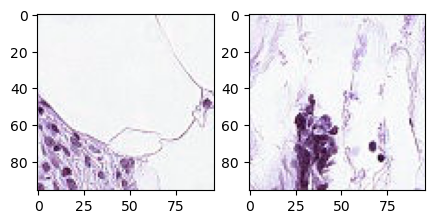

In [48]:
#Display Sample Images

fig, ax = plt.subplots(1, 2, figsize = (5, 5))

ax[0].imshow(cv2.imread('train/' + train_image_df['id'][0] + '.tif'))
ax[1].imshow(cv2.imread('train/' + train_image_df['id'][1] + '.tif'))

### EDA

As shown in Charts 1 and 2 59.5% of the training examples are negative while 40.5% positive.  This imbalance could result in biased trainig so the training set is rebalanced to a 50-50 split. Chart 3 shows the new distribution to be used as the training set.  As noted above, a review of the images, image ids and labels revealed no anomolies.  No addtional data cleansing or adjustments are required.


In [49]:
#Add tif file extension
train_image_df['id'] = train_image_df['id'].astype('str') + '.tif'
train_image_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0


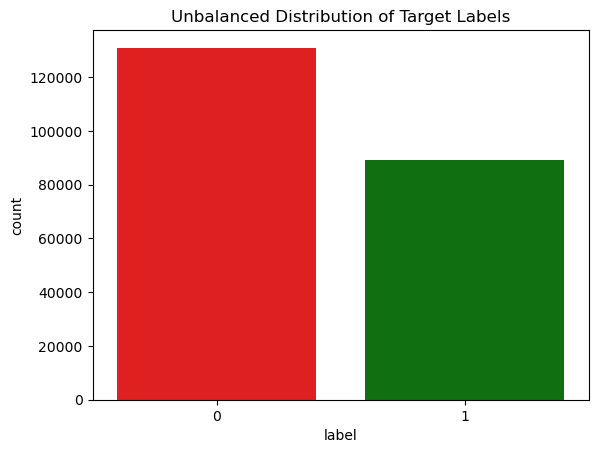

Negative Train Samples:  (89017, 2)
Positive Train Samples:  (89117, 2)
Train Image Id array shape:  (178134,)
Test Image Id array shape:  (57458,)


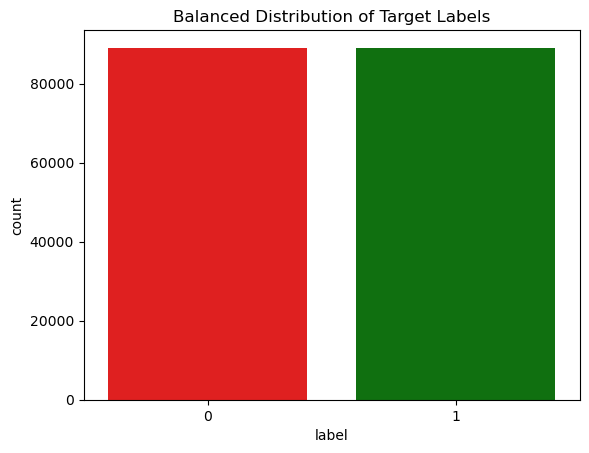

In [50]:
# Charts, data shape

plt.figure()
sns.countplot(data=train_image_df, x='label', palette=['#ff0000',"#008000"])
plt.title('Unbalanced Distribution of Target Labels')
plt.show()



# Rebalance and training arrays

#Remove 31% of negative images to balance dataset
train_image_df = train_image_df.drop(train_image_df[train_image_df['label'] == 0].sample(frac = .32).index)


train_negative_df = train_image_df[train_image_df['label'] == 0]
print('Negative Train Samples: ', train_negative_df.shape)

train_positive_df = train_image_df[train_image_df['label'] == 1]
print('Positive Train Samples: ', train_positive_df.shape)

#Convert to Numpy Array
train_image_id = train_image_df["id"].to_numpy()
test_image_id =  test_image_df["id"].to_numpy()
train_image_label = train_image_df["label"].to_numpy()

print('Train Image Id array shape: ', train_image_id.shape)
print('Test Image Id array shape: ', test_image_id.shape )


# Charts, new data shape

plt.figure()
sns.countplot(data=train_image_df, x='label', palette=['#ff0000',"#008000"])
plt.title('Balanced Distribution of Target Labels')
plt.show()


### Approach

Based on the EDA and the following approach will be deployed.

1. Establish train and test sets.  25,000 images of each classification.
2. Preprocess the data (scaling, normalization).
3. Compare two models where the batch normalization layers are in different positions.  Before and after the Activation layer (optimizer - Adam, metric - accuracy).
4. Improve best model through hyper-parameter tuning


In [51]:
#### Pre-Process Data

# BATCH_SIZE = 32
# img_height, img_width = 32, 32
# SAMPLE_SIZE = 50000
# RANDOM_STATE = 25

#Set Training set size and split
negative_training_samples = train_negative_df.sample(n=25000, random_state=25)
positive_training_samples = train_positive_df.sample(n=25000, random_state=25)
#negative_training_samples = train_image_df[train_image_df["label"] == "0"].sample(n=50000, random_state=25)
#positive_training_samples = train_image_df[train_image_df["label"] == "1"].sample(SAMPLE_SIZE, random_state=RANDOM_STATE)
full_train_set = pd.concat([negative_training_samples, positive_training_samples], axis=0).reset_index(drop=True)

full_train_set["label"].value_counts()

full_train_set.head()
full_train_set.info()

training_set, test_set = train_test_split(full_train_set, random_state=RANDOM_STATE, test_size=0.3, shuffle=True, stratify=full_train_set["label"])

# #Convert label colums to strings for data_image_generator
# full_train_set['label'] = full_train_set['label'].astype('str')
# full_train_set.head()
# full_train_set.info()


#Generate and scale images
data_image_generator = ImageDataGenerator(featurewise_center=False, zoom_range = 0.2, rotation_range = 30, rescale=1./255)

generator_train_set = data_image_generator.flow_from_dataframe(
                            dataframe=training_set,
                            directory='train/',
                            x_col="id",
                            y_col="label",                            
                            batch_size=32,                           
                            seed=25,
                            #class_mode="binary",
                            class_mode="raw",
                            target_size=(32,32))  

generator_validation_set = data_image_generator.flow_from_dataframe(
                            dataframe=test_set,
                            directory='train/',
                            x_col="id",
                            y_col="label",
                            batch_size=32,
                            seed=25,
                            #class_mode="binary",
                            class_mode="raw",
                            target_size=(32,32))



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      50000 non-null  object
 1   label   50000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 781.4+ KB
Found 35000 validated image filenames.
Found 15000 validated image filenames.


### Models

In [52]:

#Before Model - two convolution layers, flatten layer, dense layer, batch normalization before Activation Layer

before_model = Sequential()

before_model.add(Conv2D(32, (3, 3), input_shape=(32, 32, 3)))
before_model.add(BatchNormalization())
before_model.add(Activation('relu'))
before_model.add(MaxPooling2D(pool_size=(3, 3)))

before_model.add(Conv2D(64, (3, 3)))
basic_model.add(BatchNormalization())
before_model.add(Activation('relu'))
before_model.add(MaxPooling2D(pool_size=(3, 3)))
  
before_model.add(Flatten())
before_model.add(Dense(128))
before_model.add(BatchNormalization())
before_model.add(Activation('relu'))


before_model.add(Dense(1))
before_model.add(Activation('sigmoid'))

before_model.summary()

before_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#After Model - two convolution layers, flatten layer, dense layer, batch normalization after Activation Layer

after_model = Sequential()

after_model.add(Conv2D(32, (3, 3), input_shape=(32, 32, 3)))
after_model.add(Activation('relu'))
after_model.add(BatchNormalization())
after_model.add(MaxPooling2D(pool_size=(3, 3)))

after_model.add(Conv2D(64, (3, 3)))
after_model.add(Activation('relu'))
after_model.add(BatchNormalization())
after_model.add(MaxPooling2D(pool_size=(3, 3)))
  
after_model.add(Flatten())
after_model.add(Dense(128))
after_model.add(Activation('relu'))
after_model.add(BatchNormalization())

after_model.add(Dense(1))
after_model.add(Activation('sigmoid'))

after_model.summary()

after_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#Complex Model - 4 convolution layers, flatten layer, dense layer, batch normalization, two dropout layers

# complex_model =  Sequential()

# complex_model.add(Conv2D(32, (3, 3), input_shape=(32, 32, 3)))
# #complex_model.add(BatchNormalization())
# complex_model.add(Activation('relu'))
# complex_model.add(MaxPooling2D(pool_size=(3, 3)))

# complex_model.add(Conv2D(64, (3, 3)))
# #complex_model.add(BatchNormalization())
# complex_model.add(Activation('relu'))
# complex_model.add(Dropout(0.15))
# complex_model.add(MaxPooling2D(pool_size=(3, 3)))


# complex_model.add(Conv2D(128, (3, 3)))
# #complex_model.add(BatchNormalization())
# complex_model.add(Activation('relu'))
# complex_model.add(MaxPooling2D(pool_size=(3, 3)))

# complex_model.add(Conv2D(256, (3, 3)))
# #complex_model.add(BatchNormalization())
# complex_model.add(Activation('relu'))
# complex_model.add(MaxPooling2D(pool_size=(3, 3)))
  
# complex_model.add(Flatten())
# complex_model.add(Dense(128))
# #complex_model.add(BatchNormalization())
# complex_model.add(Dropout(0.25))
# complex_model.add(Activation('relu'))

# complex_model.add(Dense(1))
# complex_model.add(Activation('sigmoid'))

# complex_model.summary()

#complex_optimizer = Adam(learning_rate=0.0001)
#complex_optimizer = Adam()
#basic_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#basic_model.compile(tf.keras.optimizers.loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_47 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
module_wrapper_39 (ModuleWra (None, 30, 30, 32)        128       
_________________________________________________________________
activation_74 (Activation)   (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 8, 8, 64)          18496     
_________________________________________________________________
activation_75 (Activation)   (None, 8, 8, 64)          0         
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 2, 2, 64)        

In [53]:
#Train models
number_of_epochs = 20


before_history = before_model.fit(generator_train_set,
                    epochs = number_of_epochs, 
                    steps_per_epoch=(generator_train_set.n//generator_train_set.batch_size)//2,
                    validation_data = generator_validation_set,
                    validation_steps=(generator_validation_set.n//generator_validation_set.batch_size)//2)


after_history = after_model.fit(generator_train_set,
                    epochs = number_of_epochs, 
                    steps_per_epoch=(generator_train_set.n//generator_train_set.batch_size)//2,
                    validation_data = generator_validation_set,
                    validation_steps=(generator_validation_set.n//generator_validation_set.batch_size)//2)

Epoch 1/20
546/546 [==============================] - 160s 293ms/step - loss: 0.5036 - accuracy: 0.7589 - val_loss: 0.6369 - val_accuracy: 0.6526
Epoch 2/20
546/546 [==============================] - 170s 312ms/step - loss: 0.4693 - accuracy: 0.7810 - val_loss: 0.7986 - val_accuracy: 0.6405
Epoch 3/20
546/546 [==============================] - 115s 211ms/step - loss: 0.4528 - accuracy: 0.7915 - val_loss: 0.8006 - val_accuracy: 0.6325
Epoch 4/20
546/546 [==============================] - 111s 204ms/step - loss: 0.4321 - accuracy: 0.8041 - val_loss: 0.6142 - val_accuracy: 0.6682
Epoch 5/20
546/546 [==============================] - 96s 177ms/step - loss: 0.4321 - accuracy: 0.8003 - val_loss: 1.3555 - val_accuracy: 0.6019
Epoch 6/20
546/546 [==============================] - 107s 196ms/step - loss: 0.4248 - accuracy: 0.8082 - val_loss: 0.4622 - val_accuracy: 0.7818
Epoch 7/20
546/546 [==============================] - 95s 174ms/step - loss: 0.4163 - accuracy: 0.8100 - val_loss: 0.5651 - v

### Compare Results

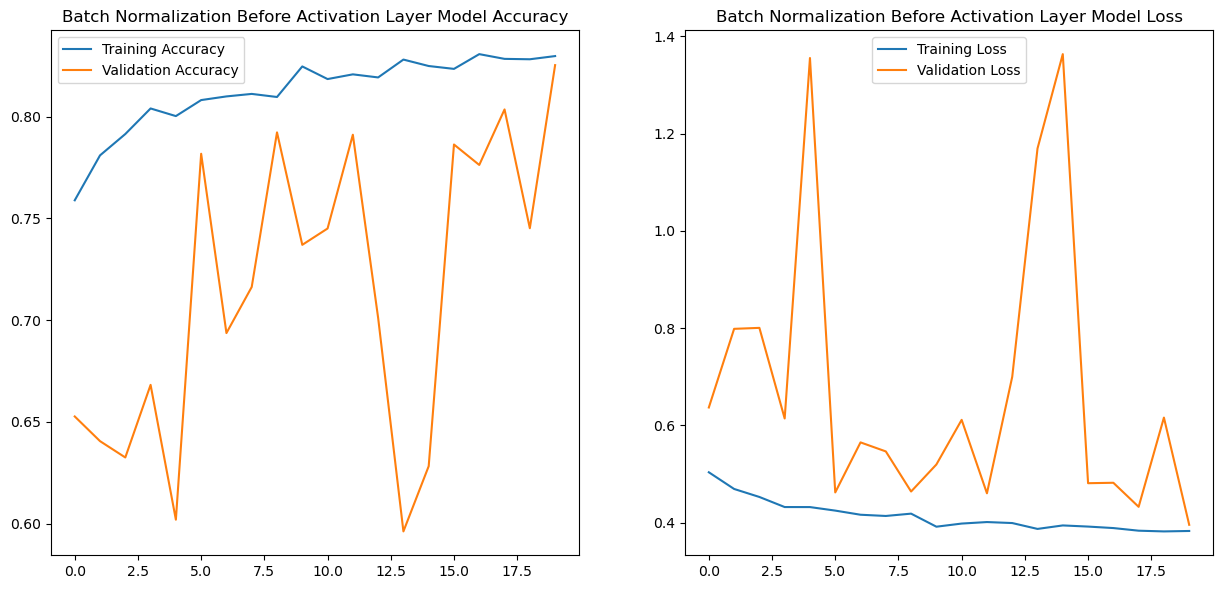

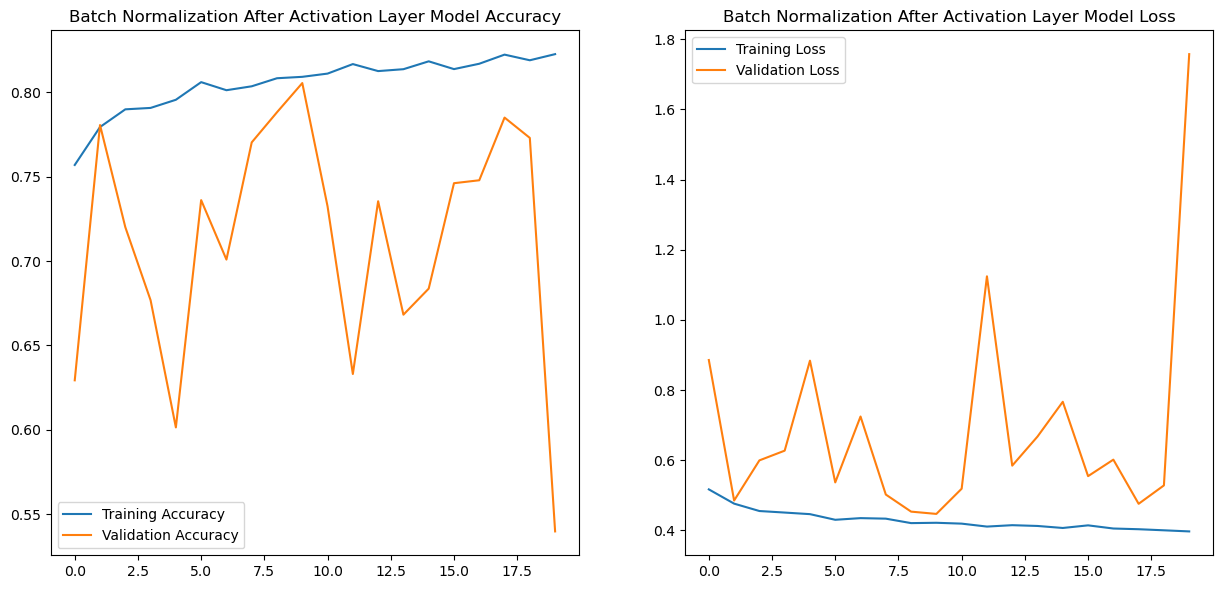

In [61]:
#Before Model
before_model_accuracy = before_history.history['accuracy']
before_model_val_acc = before_history.history['val_accuracy']
before_model_loss = before_history.history['loss']
before_model_val_loss = before_history.history['val_loss']

before_epochs_range = range(number_of_epochs)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(before_epochs_range, before_model_accuracy, label='Training Accuracy')
plt.plot(before_epochs_range, before_model_val_acc, label='Validation Accuracy')
plt.legend(loc='upper left')
plt.title('Batch Normalization Before Activation Layer Model Accuracy')

plt.subplot(2, 2, 2)
plt.plot(before_epochs_range, before_model_loss, label='Training Loss')
plt.plot(before_epochs_range, before_model_val_loss, label='Validation Loss')
plt.legend(loc='upper center')
plt.title('Batch Normalization Before Activation Layer Model Loss')
plt.show()

#After Model
after_model_accuracy = after_history.history['accuracy']
after_model_val_acc = after_history.history['val_accuracy']
after_model_loss = after_history.history['loss']
after_model_val_loss = after_history.history['val_loss']


after_epochs_range = range(number_of_epochs)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(after_epochs_range, after_model_accuracy, label='Training Accuracy')
plt.plot(after_epochs_range, after_model_val_acc, label='Validation Accuracy')
plt.legend(loc='lower left')
plt.title('Batch Normalization After Activation Layer Model Accuracy')

plt.subplot(2, 2, 2)
plt.plot(after_epochs_range, after_model_loss, label='Training Loss')
plt.plot(after_epochs_range, after_model_val_loss, label='Validation Loss')
plt.legend(loc='upper left')
plt.title('Batch Normalization After Activation Layer Model Loss')
plt.show()



In [ ]:
### Hyper-Parameter Tuning

tune momentum on batch normalization

In [ ]:

started at 50,00 images, moved to 25,000 too long
started at 20 epochs, too long

Initally started with step sizes defaulted to none and the 1 epoch took over 2 hours with accuraccy of 74%
CHanged to step size of XXX, epoch dropped to 3 mins with increased accuraccy 74%

stpe size half better accurracy 80%

Instructions: Step 1
less 
 Brief description of the problem and data (5 pts) 

Briefly describe the challenge problem and NLP. Describe the size, dimension, structure, etc., of the data. 

Instructions: Step 2
less 
Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data (15 pts)

Show a few visualizations like histograms. Describe any data cleaning procedures. Based on your EDA, what is your plan of analysis? 

Instructions: Step 3
less 
DModel Architecture (25 pts)

escribe your model architecture and reasoning for why you believe that specific architecture would be suitable for this problem. Compare multiple architectures and tune hyperparameters. 

Instructions: Step 4
less 
Results and Analysis (35 pts) 

Run hyperparameter tuning, try different architectures for comparison, apply techniques to improve training or performance, and discuss what helped.

Includes results with tables and figures. There is an analysis of why or why not something worked well, troubleshooting, and a hyperparameter optimization procedure summary.

Instructions: Step 5
less 
Conclusion (15 pts)

Discuss and interpret results as well as learnings and takeaways. What did and did not help improve the performance of your models? What improvements could you try in the future?

Instructions: Step 6
less 
Produce Deliverables: High-Quality, Organized Jupyter Notebook Report, GitHub Repository, and screenshot of Kaggle leaderboard (35 points)

In [ ]:
2.3 Clean the data / Data Preprocessing
# check the data format
print(K.image_data_format()) 
channels_last
# set random state
RANDOM_STATE = 42
# set batch size
BATCH_SIZE = 10
# set input shape
img_width, img_height = 64, 64
input_shape = (img_width, img_height, 3)
Let's balance the data and split train dataset to:

train set: is the set used for training model
validation set: is the set used during the model training to adjust the hyperparameters. (20%)
# balance the data
SAMPLE = 80000
train1 = train_df[train_df["label"] == "0"].sample(SAMPLE, random_state=RANDOM_STATE)
train2 = train_df[train_df["label"] == "1"].sample(SAMPLE, random_state=RANDOM_STATE)
train_dt = pd.concat([train1, train2], axis=0).reset_index(drop=True)
train_dt["label"].value_counts()
0    80000
1    80000
Name: label, dtype: int64
# split train dataset to train and validation set
train_data, valid_data = train_test_split(train_dt,                                                      
                                   random_state=RANDOM_STATE, 
                                   test_size=0.2, 
                                   shuffle=True, stratify=train_dt["label"])

# check value count in train and validation set
print(train_data["label"].value_counts())
print(valid_data["label"].value_counts())
0    64000

1    64000

Name: label, dtype: int64

0    16000

1    16000

Name: label, dtype: int64
Before we can proceed with building the model:

The first step to working with neural networks is to normalize the dataset, otherwise, it could take a lot longer for the network to converge on a solution.

The usual way of normalizing a dataset is to scale the features, and this is done by subtracting the mean from each feature and dividing by the standard deviation. This will put the features on the same scale somewhere between 0 — 1.

As we are working with 32 x 32 NumPy arrays representing each image and each pixel in the array has an intensity somewhere between 1 — 255, a simpler way of getting all of these images on a scale between 0–1 is to divide each array by 255.

datagen = ImageDataGenerator(featurewise_center=False,  # set input mean to 0 over the dataset                           
                             zoom_range = 0.2, # Randomly zoom image 
                             rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
                             width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
                             height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
                             horizontal_flip = True,  # randomly flip images
                             rescale=1./255)    # multiply the data by the value provided
                            
    
                           
train_generator = datagen.flow_from_dataframe(
                            dataframe=train_data,
                            directory=train_path,
                            x_col="id",
                            y_col="label",                            
                            batch_size=BATCH_SIZE,                           
                            seed=RANDOM_STATE,
                            class_mode="binary",
                            target_size=(64,64))  
Found 128000 validated image filenames belonging to 2 classes.
validation_generator = datagen.flow_from_dataframe(
                            dataframe=valid_data,
                            directory=train_path,
                            x_col="id",
                            y_col="label",
                            batch_size=BATCH_SIZE,
                            seed=RANDOM_STATE,
                            class_mode="binary",
                            target_size=(64,64))
Found 32000 validated image filenames belonging to 2 classes.
Step 3: Describe Model Architecture
Model 1:
Model is comprised of:

A simple CNN model with 3 Convolutional layers followed by max-pooling layers. A dropout layer is added at the final convolutional layer to avoid overfitting. BatchNormalization normalize the activation of the previous layer at each batch. Sigmoid is used as the activation function for the final layer of the binary classifier. Use binary-entropy loss function for our binary-class classification problem. For simplicity, use accuracy as our evaluation metrics to evaluate the model during training and testing.

optimization: Adam
learning rate: 0.0001
hidden layer activations: relu
final layer dropout: 0.4
final layer activation: sigmoid because of the binary classification
    
model = Sequential()
# first convolutional layer
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# second convolutional layer
model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
  
# third convolutional layer
model.add(Conv2D(128, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.4))

# Out layer
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.summary()
Model: "sequential"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   

=================================================================

 conv2d (Conv2D)             (None, 62, 62, 32)        896       

                                                                 

 batch_normalization (BatchN  (None, 62, 62, 32)       128       

 ormalization)                                                   

                                                                 

 activation (Activation)     (None, 62, 62, 32)        0         

                                                                 

 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         

 )                                                               

                                                                 

 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     

                                                                 

 batch_normalization_1 (Batc  (None, 29, 29, 64)       256       

 hNormalization)                                                 

                                                                 

 activation_1 (Activation)   (None, 29, 29, 64)        0         

                                                                 

 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         

 2D)                                                             

                                                                 

 conv2d_2 (Conv2D)           (None, 12, 12, 128)       73856     

                                                                 

 batch_normalization_2 (Batc  (None, 12, 12, 128)      512       

 hNormalization)                                                 

                                                                 

 activation_2 (Activation)   (None, 12, 12, 128)       0         

                                                                 

 max_pooling2d_2 (MaxPooling  (None, 6, 6, 128)        0         

 2D)                                                             

                                                                 

 flatten (Flatten)           (None, 4608)              0         

                                                                 

 dense (Dense)               (None, 256)               1179904   


                                                                 

 batch_normalization_3 (Batc  (None, 256)              1024      

 hNormalization)                                                 

                                                                 

 activation_3 (Activation)   (None, 256)               0         

                                                                 

 dropout (Dropout)           (None, 256)               0         

                                                                 

 dense_1 (Dense)             (None, 1)                 257       

                                                                 

 activation_4 (Activation)   (None, 1)                 0         

                                                                 

=================================================================

Total params: 1,275,329

Trainable params: 1,274,369

Non-trainable params: 960

_________________________________________________________________
Let's compile the model now using Adam as our optimizer and binary crossentropy as the loss function. We are using a lower learning rate of 0.0001 for a smoother curve.

# compile the model
opt = Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
# let’s train our model for 20 epochs
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size
history = model.fit(train_generator,
                    epochs = 20 , 
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data = validation_generator,
                    validation_steps=STEP_SIZE_VALID)
            
Epoch 1/20

12800/12800 [==============================] - 697s 54ms/step - loss: 0.4683 - accuracy: 0.7861 - val_loss: 0.3623 - val_accuracy: 0.8436

Epoch 2/20

12800/12800 [==============================] - 701s 55ms/step - loss: 0.4092 - accuracy: 0.8194 - val_loss: 0.6046 - val_accuracy: 0.7189

Epoch 3/20

12800/12800 [==============================] - 713s 56ms/step - loss: 0.3906 - accuracy: 0.8296 - val_loss: 0.5020 - val_accuracy: 0.7549

Epoch 4/20

12800/12800 [==============================] - 729s 57ms/step - loss: 0.3741 - accuracy: 0.8383 - val_loss: 0.3132 - val_accuracy: 0.8693

Epoch 5/20

12800/12800 [==============================] - 725s 57ms/step - loss: 0.3611 - accuracy: 0.8466 - val_loss: 0.4342 - val_accuracy: 0.7918

Epoch 6/20

12800/12800 [==============================] - 729s 57ms/step - loss: 0.3494 - accuracy: 0.8520 - val_loss: 0.3308 - val_accuracy: 0.8572

Epoch 7/20

12800/12800 [==============================] - 701s 55ms/step - loss: 0.3422 - accuracy: 0.8552 - val_loss: 0.4511 - val_accuracy: 0.7863

Epoch 8/20

12800/12800 [==============================] - 4591s 359ms/step - loss: 0.3346 - accuracy: 0.8604 - val_loss: 0.2900 - val_accuracy: 0.8781

Epoch 9/20

12800/12800 [==============================] - 2214s 173ms/step - loss: 0.3297 - accuracy: 0.8636 - val_loss: 0.3425 - val_accuracy: 0.8518

Epoch 10/20

12800/12800 [==============================] - 3386s 265ms/step - loss: 0.3237 - accuracy: 0.8666 - val_loss: 0.3431 - val_accuracy: 0.8586

Epoch 11/20

12800/12800 [==============================] - 708s 55ms/step - loss: 0.3194 - accuracy: 0.8687 - val_loss: 0.5548 - val_accuracy: 0.7660

Epoch 12/20

12800/12800 [==============================] - 709s 55ms/step - loss: 0.3146 - accuracy: 0.8711 - val_loss: 0.2735 - val_accuracy: 0.8902

Epoch 13/20

12800/12800 [==============================] - 708s 55ms/step - loss: 0.3124 - accuracy: 0.8727 - val_loss: 0.3172 - val_accuracy: 0.8640

Epoch 14/20

12800/12800 [==============================] - 703s 55ms/step - loss: 0.3083 - accuracy: 0.8742 - val_loss: 0.2580 - val_accuracy: 0.8932

Epoch 15/20

12800/12800 [==============================] - 713s 56ms/step - loss: 0.3032 - accuracy: 0.8768 - val_loss: 0.2570 - val_accuracy: 0.8950

Epoch 16/20

12800/12800 [==============================] - 709s 55ms/step - loss: 0.2990 - accuracy: 0.8789 - val_loss: 0.3435 - val_accuracy: 0.8635

Epoch 17/20

12800/12800 [==============================] - 701s 55ms/step - loss: 0.2997 - accuracy: 0.8790 - val_loss: 0.2426 - val_accuracy: 0.9014

Epoch 18/20

12800/12800 [==============================] - 698s 55ms/step - loss: 0.2958 - accuracy: 0.8807 - val_loss: 0.3165 - val_accuracy: 0.8632

Epoch 19/20

12800/12800 [==============================] - 699s 55ms/step - loss: 0.2929 - accuracy: 0.8824 - val_loss: 0.2443 - val_accuracy: 0.9023

Epoch 20/20

12800/12800 [==============================] - 703s 55ms/step - loss: 0.2905 - accuracy: 0.8821 - val_loss: 0.2681 - val_accuracy: 0.8869
model.save("../Week3/my_model1")
WARNING:absl:Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.
INFO:tensorflow:Assets written to: ../Week3/my_model1/assets
INFO:tensorflow:Assets written to: ../Week3/my_model1/assets
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Model 2
Next, let's use Earlystopping to avoid overfitting by terminating the process early. Since the goal of a training is to minimize the loss. With this, we can set up the metric as:

+ monitor : val_loss, value being monitored.  
+ mode: min, training will stop when the quantity monitored has stopped decreasing.   
+ patience: 3, number of epochs with no improvement after which training will be stopped.  

Moreover, let's use Reduce learning rate when a metric has stopped improving. Models often benefit from reducing the learning rate by a factor of 2-10 once learning stagnates. This callback monitors a quantity and if no improvement is seen for a 'patience' number of epochs, the learning rate is reduced.

+ factor: factor by which the learning rate will be reduced (new_learning_rate = learning_rate * factor).  
+ min_lr: lower bound on the learning rate.  

A model.fit() training loop will check at end of every epoch whether the loss is no longer decreasing, considering the min_delta and patience if applicable. Once it's found no longer decreasing, model.stop_training is marked True and the training terminates.

# define an Earlystopping
checkpoint_filepath = '../Week3/checkpoint'
mp= tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True,
                               verbose=1, save_best_only=True)
es= tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=3, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, 
                                   verbose=1, mode='min', min_lr=0.00001)
callback=[es, mp, reduce_lr]
new_model = Sequential()
# first convolutional layer
new_model.add(Conv2D(32, (3, 3), input_shape=input_shape))
new_model.add(BatchNormalization())
new_model.add(Activation('relu'))
new_model.add(MaxPooling2D(pool_size=(2, 2)))

# second convolutional layer

new_model.add(Conv2D(64, (3, 3)))
new_model.add(BatchNormalization())
new_model.add(Activation('relu'))
new_model.add(MaxPooling2D(pool_size=(2, 2)))
  
# third convolutional layer
new_model.add(Conv2D(128, (3, 3)))
new_model.add(BatchNormalization())
new_model.add(Activation('relu'))
new_model.add(MaxPooling2D(pool_size=(2, 2)))

new_model.add(Flatten())
new_model.add(Dense(256))
new_model.add(BatchNormalization())
new_model.add(Activation('relu'))
new_model.add(Dropout(0.4))

# Out layer
new_model.add(Dense(1))
new_model.add(Activation('sigmoid'))

new_model.summary()
Model: "sequential_1"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   

=================================================================

 conv2d_3 (Conv2D)           (None, 62, 62, 32)        896       

                                                        
        
=================================================================

Total params: 1,275,329

Trainable params: 1,274,369

Non-trainable params: 960

_________________________________________________________________
# compile new model
new_model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['accuracy'])
# let’s train our model for 20 epochs
new_history = new_model.fit(train_generator,
                    epochs = 20 , 
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data = validation_generator,
                    validation_steps=STEP_SIZE_VALID,
                    callbacks=callback)
Epoch 1/20

12800/12800 [==============================] - ETA: 0s - loss: 0.4709 - accuracy: 0.7863

Epoch 1: val_loss improved from inf to 0.44097, saving model to ../Week3/checkpoint

12800/12800 [==============================] - 708s 55ms/step - loss: 0.4709 - accuracy: 0.7863 - val_loss: 0.4410 - val_accuracy: 0.8045 - lr: 1.0000e-04

Epoch 2/20

12800/12800 [==============================] - ETA: 0s - loss: 0.40
        
new_model.save("../Week3/my_model2")
WARNING:absl:Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.
INFO:tensorflow:Assets written to: ../Week3/my_model2/assets
INFO:tensorflow:Assets written to: ../Week3/my_model2/assets
new_acc = new_history.history['accuracy']
new_val_acc = new_history.history['val_accuracy']
new_loss = new_history.history['loss']
new_val_loss = new_history.history['val_loss']
epochs_range = range(7)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, new_acc, label='Training Accuracy')
plt.plot(epochs_range, new_val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, new_loss, label='Training Loss')
plt.plot(epochs_range, new_val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


Model 1
val_loss1, val_acc1 = model.evaluate(validation_generator)
print('val_loss_model1:', val_loss1)
print('val_acc_model1:', val_acc1)
3200/3200 [==============================] - 102s 32ms/step - loss: 0.2670 - accuracy: 0.8864

val_loss_model1: 0.26701804995536804

val_acc_model1: 0.8864062428474426
# predict validation dataset
predictions1 = model.predict(validation_generator, verbose=1)
predictions1
3200/3200 [==============================] - 101s 32ms/step
array([[0.03428283],
       [0.14390497],
       [0.05418937],
       ...,
       [0.1562683 ],
       [0.99227035],
       [0.23418935]], dtype=float32)
# calculate auc_score
fpr1, tpr1, thresholds1 = roc_curve(y_true, predictions1, pos_label=1)
auc_score1 = auc(fpr1, tpr1)
auc_score1
0.50013395703125
plt.plot([0,1], [0,1], linestyle='--', color='blue')
plt.plot(fpr1, tpr1, label='area = {:.2f}'.format(auc_score1))
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()


We can print out the classification report to see the precision and accuracy.

# Get the prediction binary
y_pred1 = np.where(predictions1 > 0.5, 1, 0)
# print out the classification report
print(classification_report(y_true, y_pred1, target_names = ['no_tumor_tissue (Class 0)','has_tumor_tissue (Class 1)']))
                            precision    recall  f1-score   support



 no_tumor_tissue (Class 0)       0.50      0.56      0.53     16000

has_tumor_tissue (Class 1)       0.50      0.45      0.47     16000



                  accuracy                           0.50     32000

                 macro avg       0.50      0.50      0.50     32000

              weighted avg       0.50      0.50      0.50     32000


# print out the confusion matrix
cm1 = confusion_matrix(y_true, y_pred1)
sns.heatmap(cm1, annot=True, fmt=".0f")
<AxesSubplot:>
    
<AxesSubplot:>

Model 2
# the best epoch will be used.
new_model.load_weights('../Week3/checkpoint')
val_loss2, val_acc2 = new_model.evaluate(validation_generator)
print('val_loss_model2:', val_loss2)
print('val_acc_model2:', val_acc2)
3200/3200 [==============================] - 101s 32ms/step - loss: 0.3265 - accuracy: 0.8601

val_loss_model2: 0.32647979259490967

val_acc_model2: 0.8601250052452087
# predict validation dataset
predictions2 = new_model.predict(validation_generator)
predictions2
3200/3200 [==============================] - 102s 32ms/step
array([[0.432638  ],
       [0.18982337],
       [0.81373936],
       ...,
       [0.98624164],
       [0.12874842],
       [0.6048674 ]], dtype=float32)


# calculate auc_score
fpr2, tpr2, thresholds2 = roc_curve(y_true, predictions2, pos_label=1)
auc_score2 = auc(fpr2, tpr2)
auc_score2
0.499510451171875
plt.plot([0,1], [0,1], linestyle='--', color='blue')
plt.plot(fpr2, tpr2, label='area = {:.2f}'.format(auc_score2))
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

# Get the prediction binary
y_pred2 = np.where(predictions2 > 0.5, 1, 0)
# print out the classification report
print(classification_report(y_true, y_pred2, target_names = ['no_tumor_tissue (Class 0)','has_tumor_tissue (Class 1)']))
                            precision    recall  f1-score   support



 no_tumor_tissue (Class 0)       0.50      0.47      0.49     16000

has_tumor_tissue (Class 1)       0.50      0.53      0.52     16000



                  accuracy                           0.50     32000
    
    
Predict test data and print out the submission
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
                            dataframe=test_df,
                            directory=test_path,
                            x_col="id",
                            y_col=None,
                            batch_size=BATCH_SIZE,
                            shuffle=False,
                            seed=RANDOM_STATE,
                            class_mode=None,
                            target_size=(64,64))
Found 57458 validated image filenames.
# predict validation dataset
t_predictions = new_model.predict(test_generator, verbose=1)
t_predictions
5746/5746 [==============================] - 108s 19ms/step
array([[0.13753963],
       [0.0328943 ],
       [0.17902558],
       ...,
       [0.03642212],
       [0.02054871],
       [0.4093984 ]], dtype=float32)
# Get the new prediction binary
test_pred = np.where(t_predictions > 0.5, 1, 0)
# create submission dataframe
test_predictions = np.transpose(test_pred)[0]
submission = pd.DataFrame()
submission['id'] = test_df['id'].apply(lambda x: x.split('.')[0])
submission['label'] = test_predictions
submission.head()

	id	label
0	fd0a060ef9c30c9a83f6b4bfb568db74b099154d	0
1	1f9ee06f06d329eb7902a2e03ab3835dd0484581	0
2	19709bec800f372d0b1d085da6933dd3ef108846	0
3	7a34fc34523063f13f0617f7518a0330f6187bd3	0
4	93be720ca2b95fe2126cf2e1ed752bd759e9b0ed	0
# view test prediction counts
submission['label'].value_counts()
0    43117
1    14341
Name: label, dtype: int64
# plot the count of each label
fig, ax = plt.subplots(figsize=(6,6))
sns.countplot(data=submission, y='label', ax=ax).set(title='\nFigure 5. The Count of Each Label\n')

# plot the proportion of each label
labels = submission['label'].unique().tolist()
counts = submission['label'].value_counts()
sizes = [counts[v] for v in labels]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%0.2f%%')
ax1.axis('equal')
plt.title("\nFigure 6. The Proportion of Each Label\n")
plt.tight_layout()
plt.show()

# convert to csv to submit to competition
#submission.to_csv('submission.csv', index=False)
submission.to_csv('../Week3/submission.csv', index=False)
Step 5: Conclusion
compare_table = pd.DataFrame({"Model": ["Model1", "Model2"],
                        "val_acc": [round(val_acc1, 3), round(val_acc2, 3)],
                        "val_loss": [round(val_loss1, 3), round(val_loss2, 3)],
                        "AUC": [round(auc_score1, 2), round(auc_score2, 2)]})
compare_table
Model	val_acc	val_loss	AUC
0	Model1	0.886	0.267	0.5
1	Model2	0.860	0.326	0.5
Model 1 has the higher validation accuracy and lower validation loss compare to model2, However AUC score of two 
models are just the same although it took more time to run model1 than model2 because model2 used Earlystopping and
Reduce Learning Rate to optimize the model. I think these two models might be overfitting, so besides these two models,
I tried building some models with different learning rate and different values of dense, drop out. For example,
when I chose a learning rate like 0.00001, I observed that the model just ran and ended up with an early stop 
at epoch 4 because of the learning rate was too small, so it was stuck at epoch 4. But due to the limitation 
of time and memory, I could just build these simple CNN models and get AUC of 0.5. Hence, I believe that 
there are many ways could improve the result such as run this model by increasing the number of epochs or 
trying to test with many different parameters might get better results.